# Prvi domaci zadatak

## Dragana Ninkovic 2023/3010

In [84]:
S = 3+0+1+0;
S%3

1

## Unos podataka i pretprocesiranje

In [85]:
# Import liraries
import numpy as np;
import matplotlib.pyplot as plt;

In [86]:
# Read data
data = np.loadtxt("C:/Users/Dragana/Downloads/MU_DZ1/data.csv", delimiter = ',');

In [87]:
# Shuffle data
np.random.shuffle(data)

In [88]:
data.shape

(342, 6)

In [89]:
# Form matrix X and vector y
X = data[:, 0:5];
y = data[:,5].reshape(X.shape[0],1);

In [90]:
print("Shape of matrix X is:")
print(X.shape)
print("Shape of vector y is:")
print(y.shape)

Shape of matrix X is:
(342, 5)
Shape of vector y is:
(342, 1)


In [91]:
# Add polinomial features
for i in range(0,5):
    for j in range(0,i+1):
            Xij = (X[:,i]*X[:,j]).reshape(X.shape[0],1)
            X = np.concatenate((X,Xij), axis = 1);

In [92]:
# Check dimensions - n_samples = 342 n_features = 5*4/2 + 2*5  = 20
n_samples, n_features = X.shape;

In [93]:
print("Shape of matrix X is:")
print(X.shape)
print("Shape of vector y is:")
print(y.shape)

Shape of matrix X is:
(342, 20)
Shape of vector y is:
(342, 1)


In [94]:
# Split data on training and test set
n_train_samples = int(n_samples*0.8)
X_train = X[0:(n_train_samples),:]
y_train = y[0:(n_train_samples)]
X_test = X[n_train_samples:,:]
y_test = y[n_train_samples:]

In [95]:
# Check dimensions
print("Shape of matrix X_train is:")
print(X_train.shape)
print("Shape of matrix X_test is:")
print(X_test.shape)
print("Shape of matrix y_train is:")
print(y_train.shape)
print("Shape of matrix y_test is:")
print(y_test.shape)

Shape of matrix X_train is:
(273, 20)
Shape of matrix X_test is:
(69, 20)
Shape of matrix y_train is:
(273, 1)
Shape of matrix y_test is:
(69, 1)


In [96]:
# X statistic 
X_mean = np.mean(X_train, axis = 0).reshape(1,20);
X_std = np.std(X_train, axis = 0).reshape(1,20);
X_norm = (X_train-X_mean)/X_std;

In [97]:
print("Shape of matrix X_mean is:")
print(X_mean.shape)
print("Shape of matrix X_std is:")
print(X_std.shape)
print("Shape of matrix X is:")
print(X.shape)

Shape of matrix X_mean is:
(1, 20)
Shape of matrix X_std is:
(1, 20)
Shape of matrix X is:
(342, 20)


In [98]:
# Y statistic
y_mean = np.mean(y_train)
y_std = np.std(y_train)

In [99]:
print("Range of y values is:")
print([np.min(y_train), np.max(y_train)])
print("Mean of y values is:")
print(np.mean(y_train))
print("Median of y values is:")
print(np.median(y_train))
print("Std of y values is:")
print(np.std(y_train))

Range of y values is:
[31.0, 336.0]
Mean of y values is:
148.5897435897436
Median of y values is:
135.0
Std of y values is:
78.19197871797138


Text(0.5, 0.98, 'Input data')

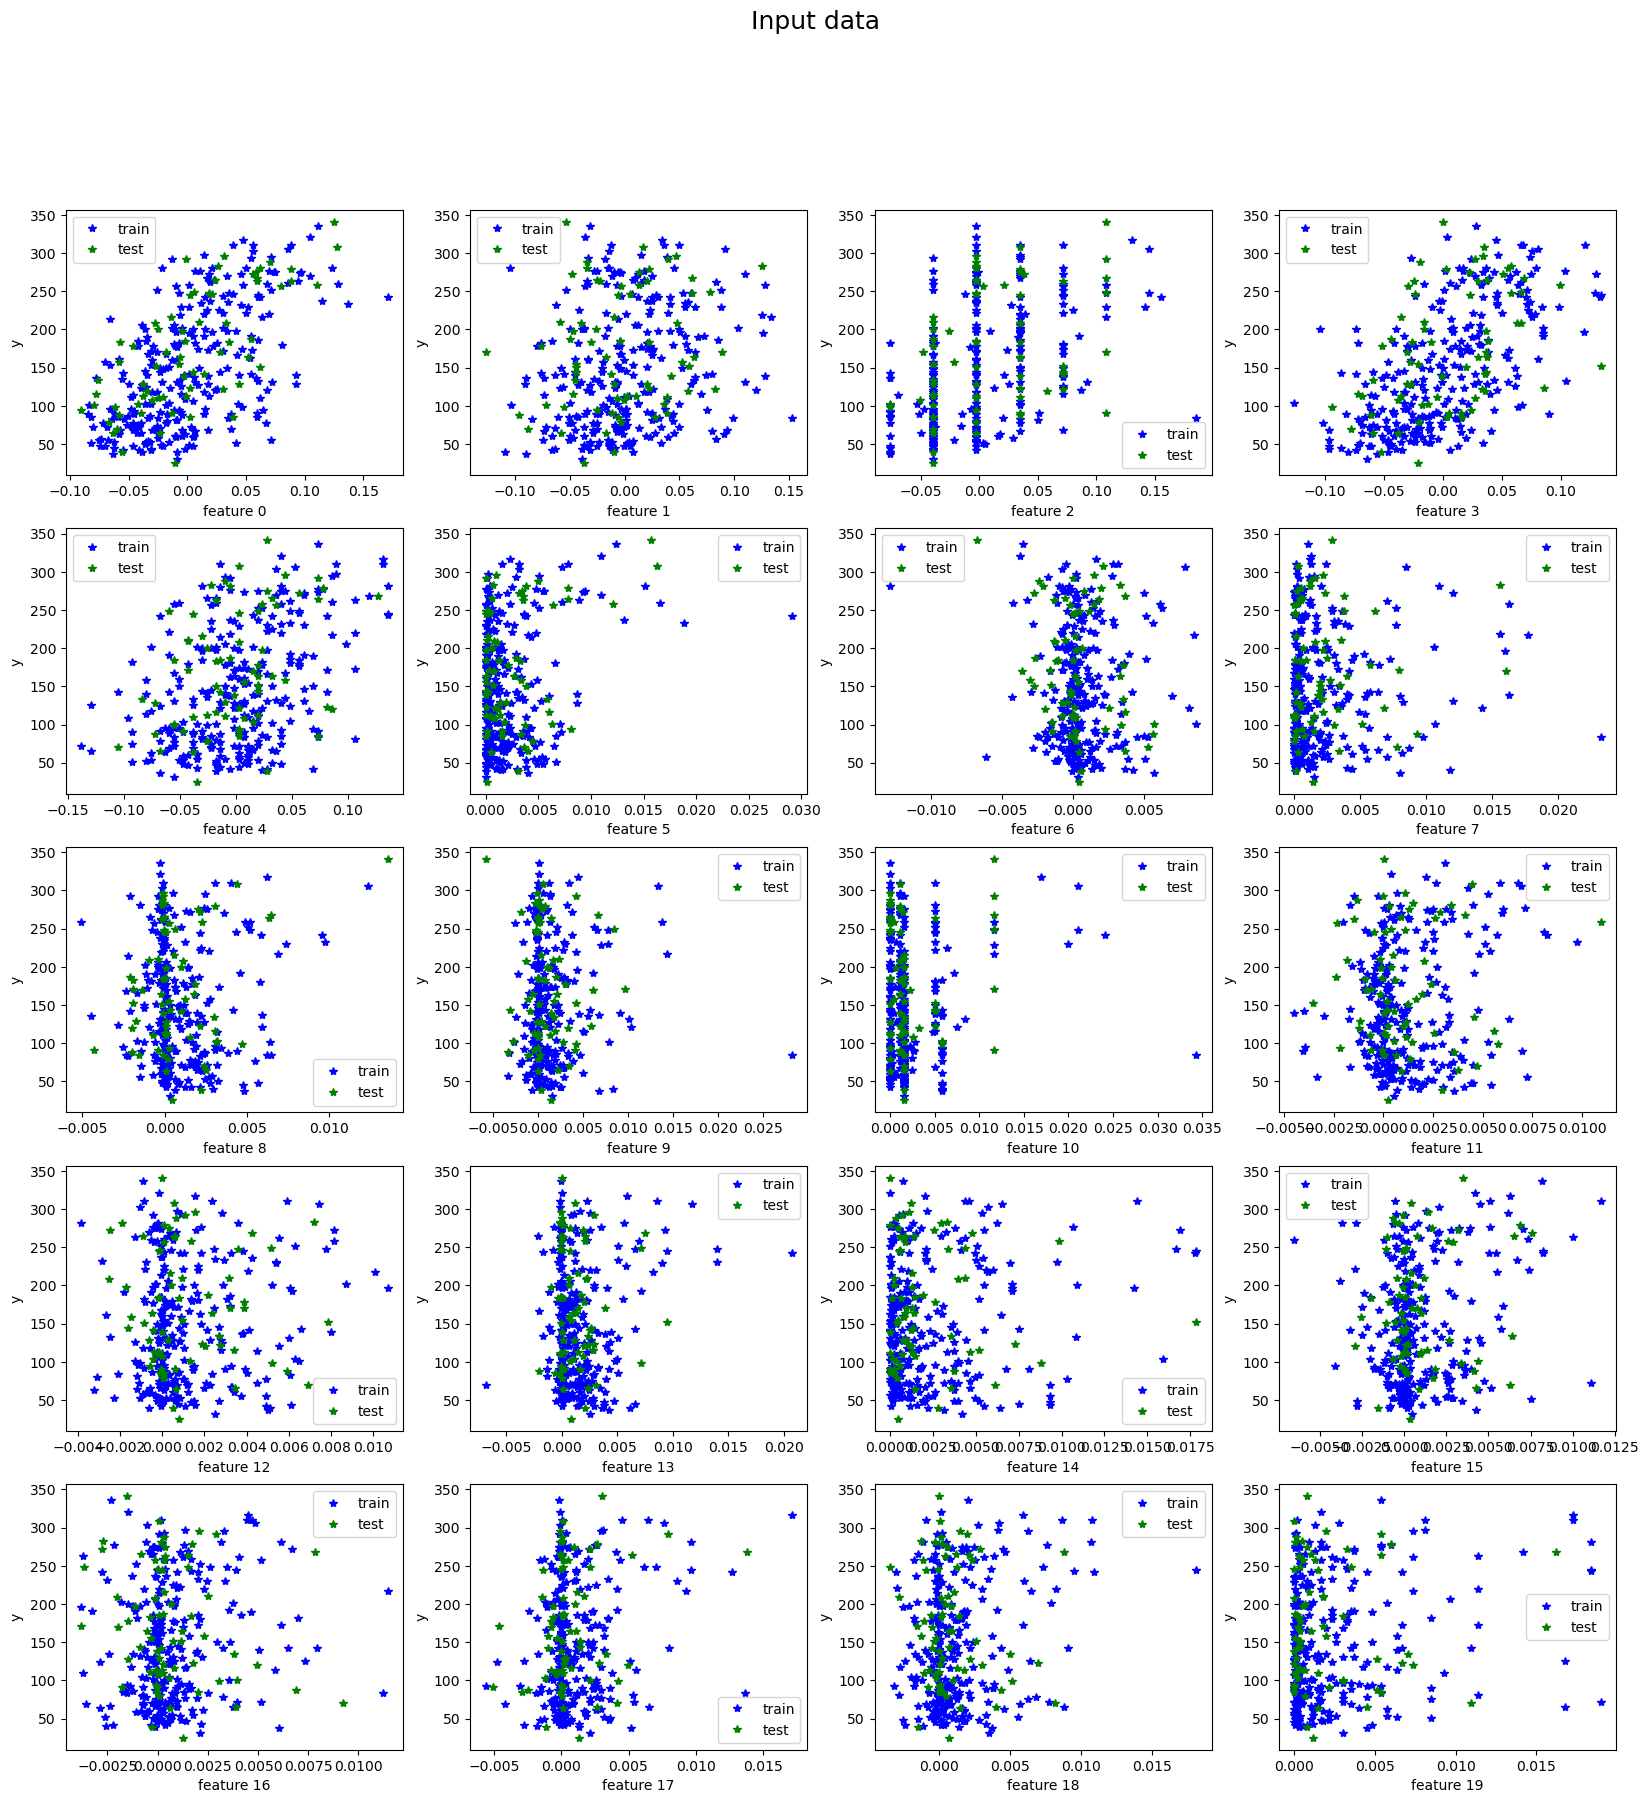

In [100]:
fig,axs = plt.subplots(ncols = 4, nrows = 5, figsize = (20,20) )
ax = axs.ravel();
for i in range(0,n_features):
    ax[i].plot(X_train[:,i],y_train,'b*')
    ax[i].plot(X_test[:,i],y_test,'g*')
    ax[i].set_xlabel('feature '+str(i))
    ax[i].set_ylabel('y')
    ax[i].legend(['train','test'])
fig.suptitle('Input data',fontsize=18)

## Funkcija za kros validaciju i hiperparametri

* Za kros validaciju potrebno nam je da izaberemo broj skupova na koje delimo obucavajuci skup. S obzirom da broj podataka nije tako veliki uzeta je najcesce koriscena podela na 5 podskupova.
* Za broj iteracija je takodje uzeta standardna vrednost 1000 jer povecavanje ovog hiperparametra nije dovodilo do poboljsanja rezultata.
* Sa eta je oznacena konstanta regularizacije koja se odredjuje pomocu metoda unakrsne validacije. Isprobani su razni stepeni broja 10: $$ \eta \subset [10^{-11},10^2]$$  Kako je utvrdjeno da se najcesce dobija parametar koji se nalazi u opsegu 0.1 do 10 taj interval je dodatno linearno podeljen na poddelove sa dvema linearnim funkcijama - prvom sa korakom 0.1 i drugom sa korakom 1.
* Za konstantu ucenja isprobane su vrednosti 0.001, 0.01 i 0.1. Najbolji rezultati dobijeni su sa 0.01 pa je ona izabrana kao konacna.

In [101]:
# Basic hyperparameters
num_folds = 5
num_iterations = 1000
fold_size = n_samples // num_folds
etas = [1e-11,1e-10,1e-9,0.00000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,100]
lr = 0.01

Ideja unakrsne validacije je da pokusamo da izaberemo hiperparametre naseg modela tako da ne dodje do preobucavanja, a da pri tome pokusamo da u maksimalnoj meri iskoristimo nase ulazne podatke. Podatke prvo izmesamo slucajno (Sto je uradjeno odmah nakon ucitavanja podataka) i zatim prvo izdvojimo test skup koji ne diramo do momenta kada su odredjeni svi parametri i hiperparametri. Nakon toga, ostatak podataka podelimo na k delova i ciklicno menjamo deo koji nam predstavlja validacioni skup dok nam ostala 4 dela predstavljaju obucavajuci skup. Obucavajuci skup koristimo da bismo odredili parametre standardizacije i obucili nas model dok nam validacioni skup koristi da bismo odredili gresku modela. Krajnja greska jedne iteracije se odredjuje kao srednja greska svakog od ovih k modela. U procesu cuvamo srednju vrednost ovih gresaka kao i njihove standardne devijacije kako bismo prikazali grafik i sa njega dosli do zakljucka o optimalnoj vrednosti hiperparametra.

In [126]:
def cross_validation(X,y,num_folds,num_iterations,fold_size,etas,lr, opt):
    validation_rmse_mean = []
    validation_rmse_std = []
    train_rmse_mean = []
    train_rmse_std = []
    
    for eta in etas:
        current_train_rmse = []
        current_validation_rmse = []
        
        for fold in range(num_folds):
            # Split data into training and validation set
            start = fold * fold_size
            end = (fold + 1) * fold_size
            
            X_validation = X[start:end]
            y_validation = y[start:end]
            
            X_train = np.concatenate((X[:start], X[end:]), axis=0)
            y_train = np.concatenate((y[:start], y[end:]))
            
            # Calculate statistic of X_train
            X_mean = np.mean(X_train)
            X_std = np.std(X_train)
            
            # Standardization
            X_train = (X_train - X_mean)/X_std           
            X_validation = (X_validation - X_mean)/X_std
            
            if(opt == 'gradient descent'):
                current_theta = gradient_descent(X_train, y_train, eta, learning_rate=lr, num_iterations=num_iterations)
            elif(opt == 'coordinate descent'):
                current_theta = coordinate_descent(X_train, y_train, eta,num_iterations)
            else:
                print("Not valid opt parameter.")
                
            current_intercept = np.mean(y_train)
            # Predictions on validation set
            y_pred = np.dot(X_validation, current_theta)+current_intercept
            validation_rmse = np.sqrt(np.mean((y_validation - y_pred) ** 2))
            # Predictions on train set
            y_pred = np.dot(X_train, current_theta)+current_intercept
            train_rmse = np.sqrt(np.mean((y_train - y_pred) ** 2))
            # Keep rmse results 
            current_validation_rmse.append(validation_rmse)
            current_train_rmse.append(train_rmse)
            
            
        # Keep statistics of rmse results for this iteration
        validation_rmse_mean.append(np.mean(current_validation_rmse))
        validation_rmse_std.append(np.std(current_validation_rmse))
        train_rmse_mean.append(np.mean(current_train_rmse))
        train_rmse_std.append(np.std(current_train_rmse))
        
    # Convert lists to numpy arrays    
    validation_rmse_mean = np.array(validation_rmse_mean)
    validation_rmse_std = np.array(validation_rmse_std)
    train_rmse_mean = np.array(train_rmse_mean)
    train_rmse_std = np.array(train_rmse_std)
    
    return (validation_rmse_mean,validation_rmse_std,train_rmse_mean,train_rmse_std)

## LASSO regresija

LASSO regresija podrazumeva regresiju sa regularizacijom pomocu L1 norme. S obzirom da L1 norma nije diferencijabilna ovaj metod nema analiticko resenje i mora se resavati nekim od iterativnih metoda. Najpoznatiji iterativni metod je gradijentni spust ali on nece nikad dati koeficijent koji je identicki jednak nuli zato sto ce deo gradijenta koji potice od regularizacionog dela uvek biti malo veci ili malo manji od nule. Takodje, samim tim sto ocekuje gradijent koji ne postoji u 0 mora da ga aprokismira 0 u toj tacki. Drugi, mnogo korisceniji metod za resavanje LASSO regresije je koordinatni spust. Prednost LASSO regresije u odnosu na Ridge je to sto ce cesto uspeti da neke parametre stavi na cistu nulu dok ce Ridge samo da se priblizi nuli. Za sve vrste regularizacije moze se izvesti da je nulti koeficijent (intercept) jednak proceni srednje vrednosti pa on ni u jednom od petoda nije ucen vec je postavljan na srednju vrednost obucavajuceg skupa. Takodje, da bi bilo koja regularizacija davala merodavne rezultate potrebno je da podaci budu standardizovani da ne bi iste razlike u parametrima davale razlicit uticaj i time zbunjivale algoritam koji koeficijent je vise ili manje bitan jer zelimo da budemo podjednako osetljivi na sve pravce. Standardizacija u toku unakrsne validacije se radi za svaki podskup posebno, dok se nakon odredjivanja regularizacione konstante radi nad celim skupom.

## Metod gradijentnog spusta

Smisao gradijenta je da je to vektor koji pokazuje pravac najbrzeg rasta neke funkcije sa vise parametara. Ideja gradijentnog spusta je da se krecemo sve vreme u smeru negativnog gradijenta funkcije kako bismo se sto vise priblizavali minimumu funkcije gubitka. Koriscen je sarzni gradijentni spust zato sto nema previse ulaznih podataka a dobicemo preciznije resenje jer sve vreme biramo gladju i precizniju procenu gradijenta.

In [103]:
def gradient_descent(X, y, eta, learning_rate, num_iterations):
    n_samples, n_features = X.shape
    
    theta = np.zeros((n_features,1))
    y = y.reshape(n_samples,1)
    
    intercept = np.mean(y)
    
    for _ in range(num_iterations):
        y_pred = np.dot(X,theta)+intercept
        neg_error =   y_pred - y
        J_gradient = np.dot(X.T, neg_error) / n_samples
        l1_regularization_gradient = eta * np.sign(theta);
        theta -= learning_rate * (J_gradient + l1_regularization_gradient)
    return theta

## Rezultati koje daje gradijentni spust

Greska nad obucavajucim skupom je ocekivano da raste kako povecavamo regularizacionu konstantnu zato sto ona prisiljava model da bude sto prostiji cime on pravi sve vecu gresku. Ipak, greska na validacionom skupu bi trebalo da u pocetku da bude dosta veca od obucavajuceg, zatim da opada sve vise kako dodajemo regularizaciju i u nekom momentu opet da pocne da raste jer model postaje toliko prost da lose radi na oba skupa.

### Korisnicki definisana funkcija

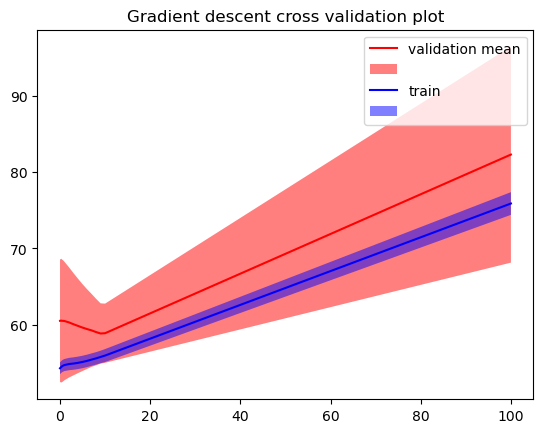

In [104]:
(validation_rmse_mean,validation_rmse_std,train_rmse_mean,train_rmse_std) = cross_validation(X_train, y_train, num_folds, num_iterations, fold_size, etas, lr,'gradient descent')

plt.figure()
plt.plot(etas,validation_rmse_mean,c='r')
plt.fill_between(etas,validation_rmse_mean-validation_rmse_std,validation_rmse_mean+validation_rmse_std, facecolor='red', alpha=0.5)
plt.plot(etas,train_rmse_mean, c= 'b')
plt.fill_between(etas,train_rmse_mean-train_rmse_std,train_rmse_mean+train_rmse_std, facecolor='blue', alpha=0.5)
plt.legend(['validation mean', '','train',''])
plt.title("Gradient descent cross validation plot")
plt.show()

In [105]:
best_eta = etas[np.argmin(validation_rmse_mean)]

Vidimo da se usrednjena vrednost greske validacije zaista priblizava greski obucavajuceg skupa do nekog momenta nakon cega ponovo pocinje da se udaljava. Ipak, kao sto vidimo, ova procena konstante regularizacije nije dovoljno precizna jer imamo veliku standardnu devijaciju. Ipak, na mestu gde je minimum je takodje ovaj pojas i najuzi, i pojas obucavajuceg i validacionog skupa se najmanje preklapaju pa mozemo uzeti tu procenu jer deluje ujedno i kao najbolja koju mozemo zakljuciti na osnovu ove slike. Primetimo takodje da je interval poverenja nad trening skupom mnogo uzi nego nad validacionim iz razloga sto u trening skupu imamo mnogo vise podataka i imamo dosta preklapanja izmedju susednih podataka.

In [106]:
X_train = (X_train - X_mean)/X_std;
X_test = (X_test - X_mean)/X_std;
best_intercept = np.mean(y_train)

In [107]:
best_theta = gradient_descent(X_train,y_train,best_eta,lr,num_iterations);

### Ugradjena funkcija

In [108]:
from sklearn.linear_model import LassoCV

lasso_reg = LassoCV(cv=5, alphas=etas).fit(X_train, np.squeeze(y_train))

### Uporedni prikaz parametara

Text(0.5, 1.0, 'Regression coefficients')

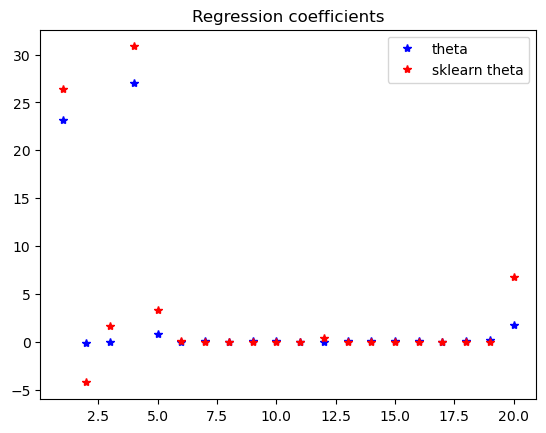

In [109]:
plt.figure()
plt.plot(range(1,21),best_theta,'b*')
plt.plot(range(1,21),lasso_reg.coef_,'r*')
plt.legend(['theta','sklearn theta'])
plt.title("Regression coefficients")

In [122]:
print("Lasso coefficients:")
print("Custom function:", best_theta.T)
print("Built-in function:", lasso_reg.coef_)

Lasso coefficients:
Custom function: [[ 2.31952583e+01 -1.09266475e-01  1.03713958e-02  2.70105636e+01
   7.80717176e-01  1.55146181e-03  3.91599635e-02 -7.17398309e-03
   7.30101832e-02  2.12450889e-02 -3.79664134e-02  1.31454358e-02
   4.79519564e-02  6.62817421e-02  1.07520405e-01  3.81425004e-02
   8.31277262e-03  2.68914876e-02  1.47779910e-01  1.71357050e+00]]
Built-in function: [26.39699893 -4.26506423  1.6068245  30.84979026  3.29878219  0.11325436
 -0.         -0.         -0.         -0.         -0.          0.41188329
  0.          0.          0.          0.          0.          0.
  0.          6.71116843]


Vidimo da su dobijeni slicni koeficijenti, ali ipak postoje odredjene razlike. Razlog za ovo je sto je ugradjena funkcija dobila drugaciji regularizacioni koeficijent. Razlika izmedju ugradjene funkcije i korisnicki definisanog gradijentnog spusta moze se objasniti time sto ugradjena funkcija mozda ne koristi isti algoritam kao i cinjenicom da ugradjena funkcija koristi standardizovane podatke samo nad celim skupom a ne nad svakim fold-om posebno. Takdje, iako su ova dva regularizaciona koeficijenta poprilicno razlicita oba su u opsegu 1 do 10 sto pripada istom intervalu posmatranom na logaritamskoj osi, a kao sto smo videli, interval poverenja oko greske na validacionom skupu je dosta velik pa samim tim nije ni bilo moguce odrediti precizno ovu vrednost. Bitno je takodje primetiti da iako je dobijena retka matrica u oba slucaja, imamo dosta koeificijenata blizu nule ali ni jedan nije jednak nuli. Ovakav neocekivani rezultat je posledica toga sto L1 regularizacija koristi L1 normu koja nije diferencijabilna u nuli i uvek cemo dobiti vrednost jako blizu nule ali jako tesko vrednost jednaku nuli.

In [110]:
import pandas as pd
df1 = {"built_in":[lasso_reg.alpha_,lasso_reg.intercept_,lasso_reg.coef_.T,np.min(np.mean(np.sqrt(lasso_reg.mse_path_)))],"user-defined:":[best_eta, best_intercept, best_theta,np.min(validation_rmse_mean)]}
df1 = pd.DataFrame.from_dict(df1)
df1.index = ["regularization coefficient","intercept", "regression coefficients","min cross validation mean rmse"]
df1

,built_in,user-defined:
regularization coefficient,3.0,9
intercept,148.589744,148.589744
regression coefficients,"[26.396998930683438, -4.265064227809638, 1.606...","[[23.195258332084432], [-0.10926647509886735],..."
min cross validation mean rmse,57.85644,58.864983


### Uprodeni prikaz gresaka

In [117]:
y_pred_train = np.dot(X_train, best_theta)+y_mean
train_rmse = np.sqrt(np.mean((y_train - y_pred_train) ** 2))
y_pred_test = np.dot(X_test, best_theta)+y_mean
test_rmse = np.sqrt(np.mean((y_test - y_pred_test) ** 2))

In [120]:
y_pred_train_ = np.dot(X_train, lasso_reg.coef_)+lasso_reg.intercept_
train_rmse_ = np.sqrt(np.mean((y_train - y_pred_train_) ** 2))
y_pred_test_ = np.dot(X_test, lasso_reg.coef_)+lasso_reg.intercept_
test_rmse_ = np.sqrt(np.mean((y_test - y_pred_test_) ** 2))

In [121]:
df2 = {"built_in":[train_rmse_,test_rmse_,train_rmse_/(np.max(y_train)- np.min(y_train)),test_rmse_/(np.max(y_test)- np.min(y_test))],"user-defined:":[train_rmse, test_rmse,train_rmse/(np.max(y_train)- np.min(y_train)),test_rmse/(np.max(y_test)- np.min(y_test))]}
df2 = pd.DataFrame.from_dict(df2)
df2.index = ["train rmse","test rmse", "train rmse:train range","test rmse:test range"]
df2

,built_in,user-defined:
train rmse,93.734298,56.724226
test rmse,93.068995,61.287355
train rmse:train range,0.307326,0.185981
test rmse:test range,0.294522,0.193947


Mozemo primetiti da nas model daje gresku oko 20% trenutnog opsega, i da na validacionom skupu daje slicnu gresku, dok na celom trening i test skupu daje cak manju gresku nego ugradjena funkcija

Text(0.5, 0.98, 'Gradient descent results')

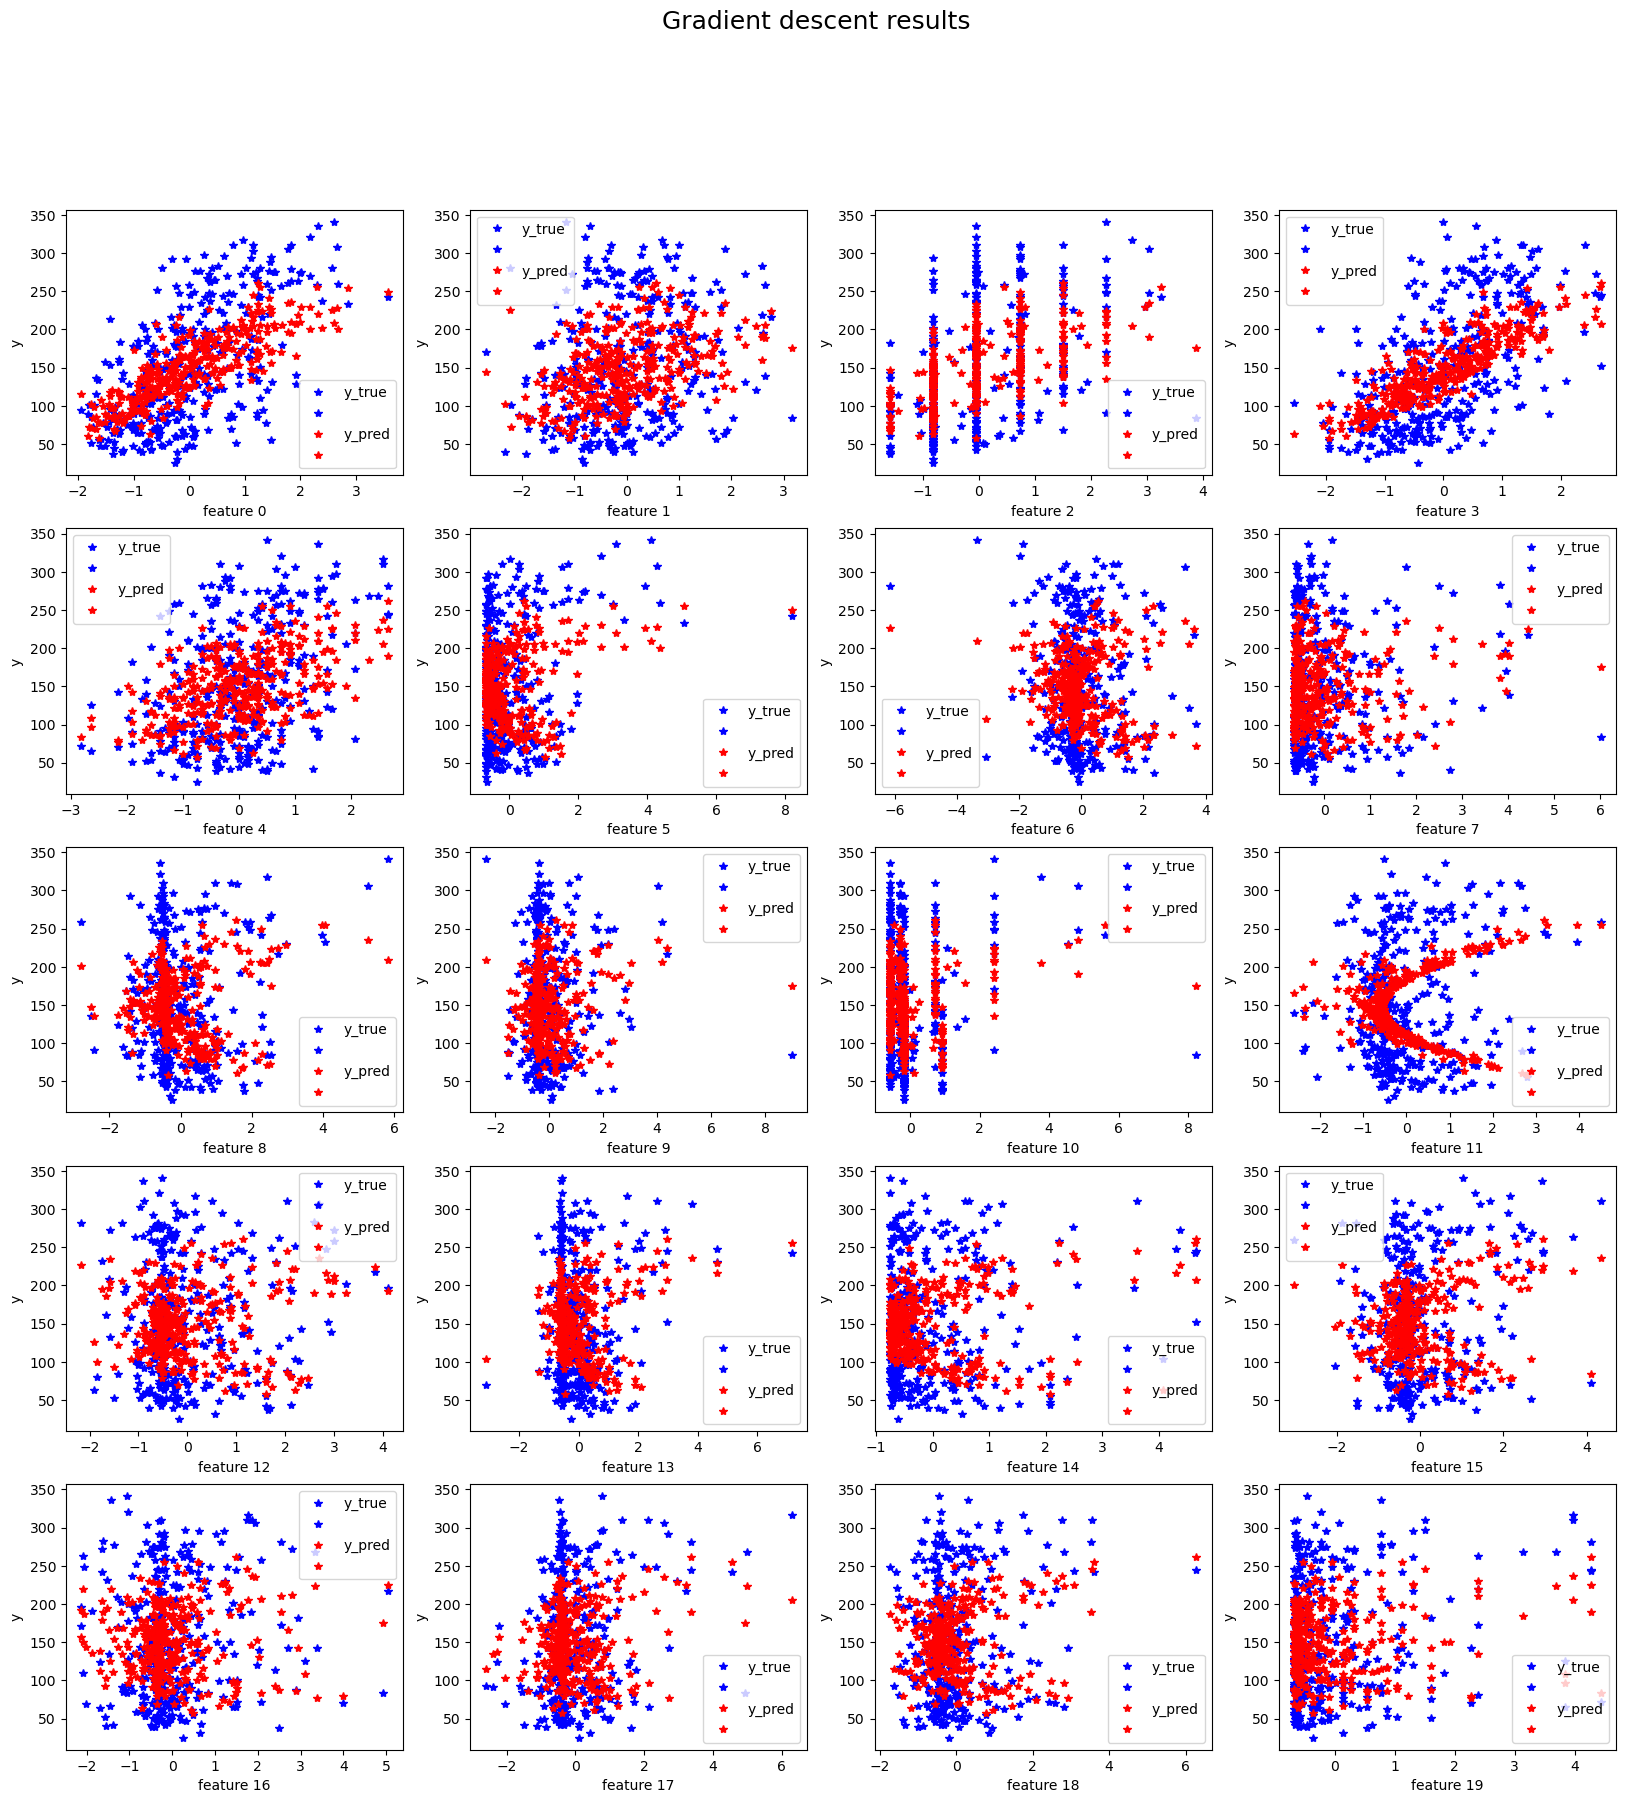

<Figure size 640x480 with 0 Axes>

In [114]:
fig,axs = plt.subplots(ncols = 4, nrows = 5, figsize = (20,20) )
ax = axs.ravel();
plt.figure()
for i in range(0,n_features):
    ax[i].plot(X_test[:,i],y_test,'b*')
    ax[i].plot(X_train[:,i],y_train,'b*')
    ax[i].plot(X_train[:,i],y_pred_train,'r*')
    ax[i].plot(X_test[:,i],y_pred_test,'r*')
    ax[i].legend(['y_true',' ','y_pred',' '])
    ax[i].set_xlabel('feature '+str(i))
    ax[i].set_ylabel('y')
fig.suptitle('Gradient descent results',fontsize=18)

Mozemo videti da je nas model relativno dobro ispratio podatke sa ulaza

## Kordinatni spust

$$L(\theta) = \frac{1}{2N}\sum_1^m(y^{(i)}-\tilde{\theta}*\tilde{x}^{(i)})^2 + R(\theta)$$

$$ \frac{dL(\theta)}{d\theta_j} = \frac{1}{N} \sum_1^m(-(y^{(i)}-\tilde{\theta}*
\tilde{x}^{(i)})*\tilde{x_j}^{(i)}) + \frac{dR(\theta)}{d\theta_j}$$

$$ \frac{dL(\theta)}{d\theta_j} = \frac{1}{N} \sum_1^m(-(y^{(i)}-\sum_{k = 1, k\neq j}^{k = n}\tilde{\theta_k}
\tilde{x_k}^{(i)} - \tilde{\theta_j}\tilde{x_j}^{(i)})*\tilde{x_j}^{(i)}) + \frac{dR(\theta)}{d\theta_j}$$

$$ \frac{dL(\theta)}{d\theta_j} = \frac{1}{N} (-\sum_{i=1}^m(y^{(i)}-\sum_{k = 1, k\neq j}^{k = n}\tilde{\theta_k}
\tilde{x_k}^{(i)})*\tilde{x_j}^{(i)}) + \frac{1}{N}\tilde{\theta_j}*\sum_{i=1}^m({\tilde{x_j}^{(i)}}^2) + \frac{dR(\theta)}{d\theta_j}= -\rho_j+\theta_jz_j+\lambda* sign(\theta_j)$$

$$ \theta_j = \frac{\rho_j-\lambda*sign(\theta_j)}{z_j}$$

$$ \theta_j = \frac{\rho_j-\lambda}{z_j}, \rho_j > \lambda$$

$$ \theta_j = 0,  -\lambda<\rho_j <\lambda$$

$$ \theta_j = \frac{\rho_j+\lambda}{z_j}, \rho_j <-\lambda$$

Iz prethodnog izvodjenja vidimo da za razliku od gradijentnog spusta, ovaj metod dobija parametre koji su identicki jednaki nuli kada je to potrebno. Takodje, mozemo videti direktno kako parametar regularizacije utice i na ostale koeficijente. Bitno je primetiti da promenljiva z moze da se unapred izracuna i da se zatim samo koriste njene vrednosti sto povecava efikasnost implementacije jer ne zavisi od parametara $\theta$. Takodje, vrednosti ove promenljive ce biti oko 1 u slucaju standardizovanih podataka tako da prakticno nisu morali biti racunati.

In [140]:
def calculate_z(X):
    z = np.sum(X * X,axis = 0);
    return z;

In [141]:
def calculate_rho_j(X,error,theta,j,intercept):
    X_j = X[:, j].reshape(X.shape[0],1)
    theta_j = theta[j]    
    y_pred_j = X_j*theta_j

    rho_j = np.sum((error+y_pred_j)*X_j)
    return rho_j

In [142]:
def coordinate_descent(X,y,alpha,num_iterations):
    n_samples, n_features = X.shape
    theta = np.zeros((n_features,1))
    y = y.reshape(n_samples,1)
    Z = calculate_z(X)/n_samples;
    intercept = np.mean(y)

    for _ in range(num_iterations):
        for j in range(n_features):      
            y_pred = np.matmul(X,theta)+intercept
            error = y-y_pred;
            rho_j = calculate_rho_j(X,error,theta,j,intercept)/n_samples
            
            if(alpha < rho_j):
                theta[j] = (rho_j-alpha)/Z[j]
            elif (-alpha > rho_j):
                theta[j] = (rho_j+alpha)/Z[j]
            else:
                theta[j] = 0;

                
    return theta;

In [143]:
(validation_rmse_mean_c,validation_rmse_std,train_rmse_mean,train_rmse_std) = cross_validation(X_train, y_train, num_folds, num_iterations, fold_size, etas, lr,'coordinate descent')

## Biranje regularizacione konstante

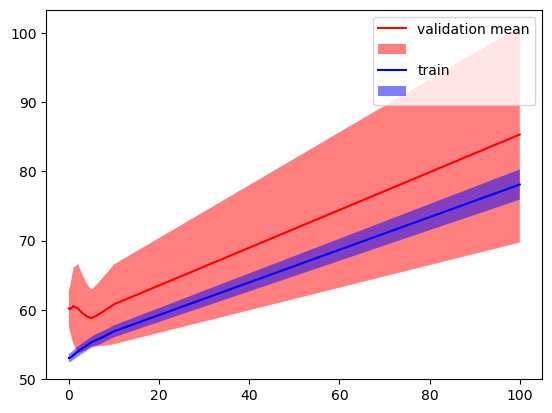

In [144]:
plt.figure()
plt.plot(etas,validation_rmse_mean_c,c='r')
plt.fill_between(etas,validation_rmse_mean_c-validation_rmse_std,validation_rmse_mean_c+validation_rmse_std, facecolor='red', alpha=0.5)
plt.plot(etas,train_rmse_mean, c= 'b')
plt.fill_between(etas,train_rmse_mean-train_rmse_std,train_rmse_mean+train_rmse_std, facecolor='blue', alpha=0.5)
plt.legend(['validation mean', '','train',''])
plt.show()

In [145]:
best_eta_c = etas[np.argmin(validation_rmse_mean)]
best_theta_c = coordinate_descent(X_train, y_train, best_eta, num_iterations=num_iterations)
best_intercept_c = best_intercept

Slicno kao ranije, najmanja standardna devijacija se poklapa sa minimumom na validacionom skupu, ali idalje validaciona kriva nije dovoljno udaljena od obucavajuce krive da bismo bilo sta tvrdili. Ocekivano, kao i malo pre, dobijamo da je u proseku greska na validacionom skupu veca kao i da ima siri interval poverenja nego na obucavajucem.

## Uporedni prikaz parametara

In [147]:
print("Lasso coefficients:")
print("Custom function(Coordinate descent):", best_theta_c.T)
print("Built-in function:", lasso_reg.coef_)

Lasso coefficients:
Custom function(Coordinate descent): [[23.22064466  0.          0.         27.18080479  0.67980973  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          1.91223115]]
Built-in function: [26.39699893 -4.26506423  1.6068245  30.84979026  3.29878219  0.11325436
 -0.         -0.         -0.         -0.         -0.          0.41188329
  0.          0.          0.          0.          0.          0.
  0.          6.71116843]


Mozemo primetiti da u ovom slucaju dobijamo jako proredjenu matricu sa koeficijentima koji su ciste nule.

Text(0.5, 1.0, 'Regression coefficients')

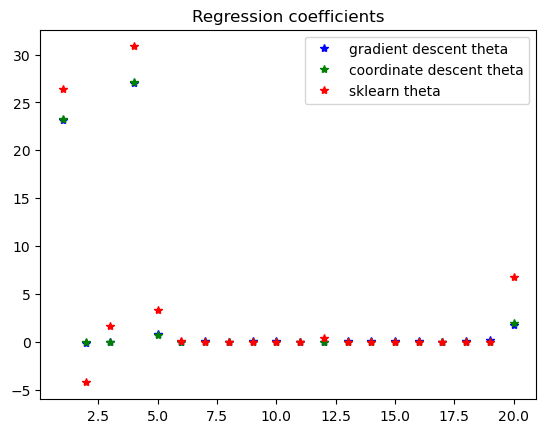

In [148]:
plt.figure()
plt.plot(range(1,21),best_theta,'b*')
plt.plot(range(1,21),best_theta_c,'g*')
plt.plot(range(1,21),lasso_reg.coef_,'r*')
plt.legend(['gradient descent theta','coordinate descent theta','sklearn theta'])
plt.title("Regression coefficients")

Vidimo da su koeficijenti dobijeni pomocu koordinatnog spusta skoro pa isti koeficijentima dobijenim pomocu gradijentnog spusta pa mozemo pretpostaviti da je za razliku kod ugradjene funkcije razlog drugacija standardizacija podataka.

In [149]:
df1 = {"built_in":[lasso_reg.alpha_,lasso_reg.intercept_,lasso_reg.coef_.T,np.min(np.mean(np.sqrt(lasso_reg.mse_path_)))],"gradient_descent:":[best_eta, best_intercept, best_theta,np.min(validation_rmse_mean)],"coordinate_descent:":[best_eta_c, best_intercept_c, best_theta_c,np.min(validation_rmse_mean_c)]}
df1 = pd.DataFrame.from_dict(df1)
df1.index = ["regularization coefficient","intercept", "regression coefficients","min cross validation mean rmse"]
df1

,built_in,gradient_descent:,coordinate_descent:
regularization coefficient,3.0,9,9
intercept,148.589744,148.589744,148.589744
regression coefficients,"[26.396998930683438, -4.265064227809638, 1.606...","[[23.195258332084432], [-0.10926647509886735],...","[[23.220644655483024], [0.0], [0.0], [27.18080..."
min cross validation mean rmse,57.85644,58.864983,58.814362


Primetimo da smo ovim metodom dobili isti regularizacioni koeficijent kao ugradjenom funkcijom i ponovo poprilicno razlicit nego gradijentnim spustom.

## Uporedni prikaz gresaka

In [150]:
y_pred_train_c = np.dot(X_train, best_theta_c)+y_mean
train_rmse_c = np.sqrt(np.mean((y_train - y_pred_train_c) ** 2))
y_pred_test_c = np.dot(X_test, best_theta_c)+y_mean
test_rmse_c = np.sqrt(np.mean((y_test - y_pred_test_c) ** 2))

In [151]:
df2 = {"built_in":[train_rmse_,test_rmse_,train_rmse_/(np.max(y_train)- np.min(y_train)),test_rmse_/(np.max(y_test)- np.min(y_test))],"gradient_descent:":[train_rmse, test_rmse,train_rmse/(np.max(y_train)- np.min(y_train)),test_rmse/(np.max(y_test)- np.min(y_test))],
      "coordinate_descent:":[train_rmse_c, test_rmse_c,train_rmse_c/(np.max(y_train)- np.min(y_train)),test_rmse_c/(np.max(y_test)- np.min(y_test))]}
df2 = pd.DataFrame.from_dict(df2)
df2.index = ["train rmse","test rmse", "train rmse:train range","test rmse:test range"]
df2

,built_in,gradient_descent:,coordinate_descent:
train rmse,93.734298,56.724226,56.724948
test rmse,93.068995,61.287355,61.282363
train rmse:train range,0.307326,0.185981,0.185983
test rmse:test range,0.294522,0.193947,0.193932


Dobijena greska sa ova dva metoda je veoma slicna.

Text(0.5, 0.98, 'Coordinate descent results')

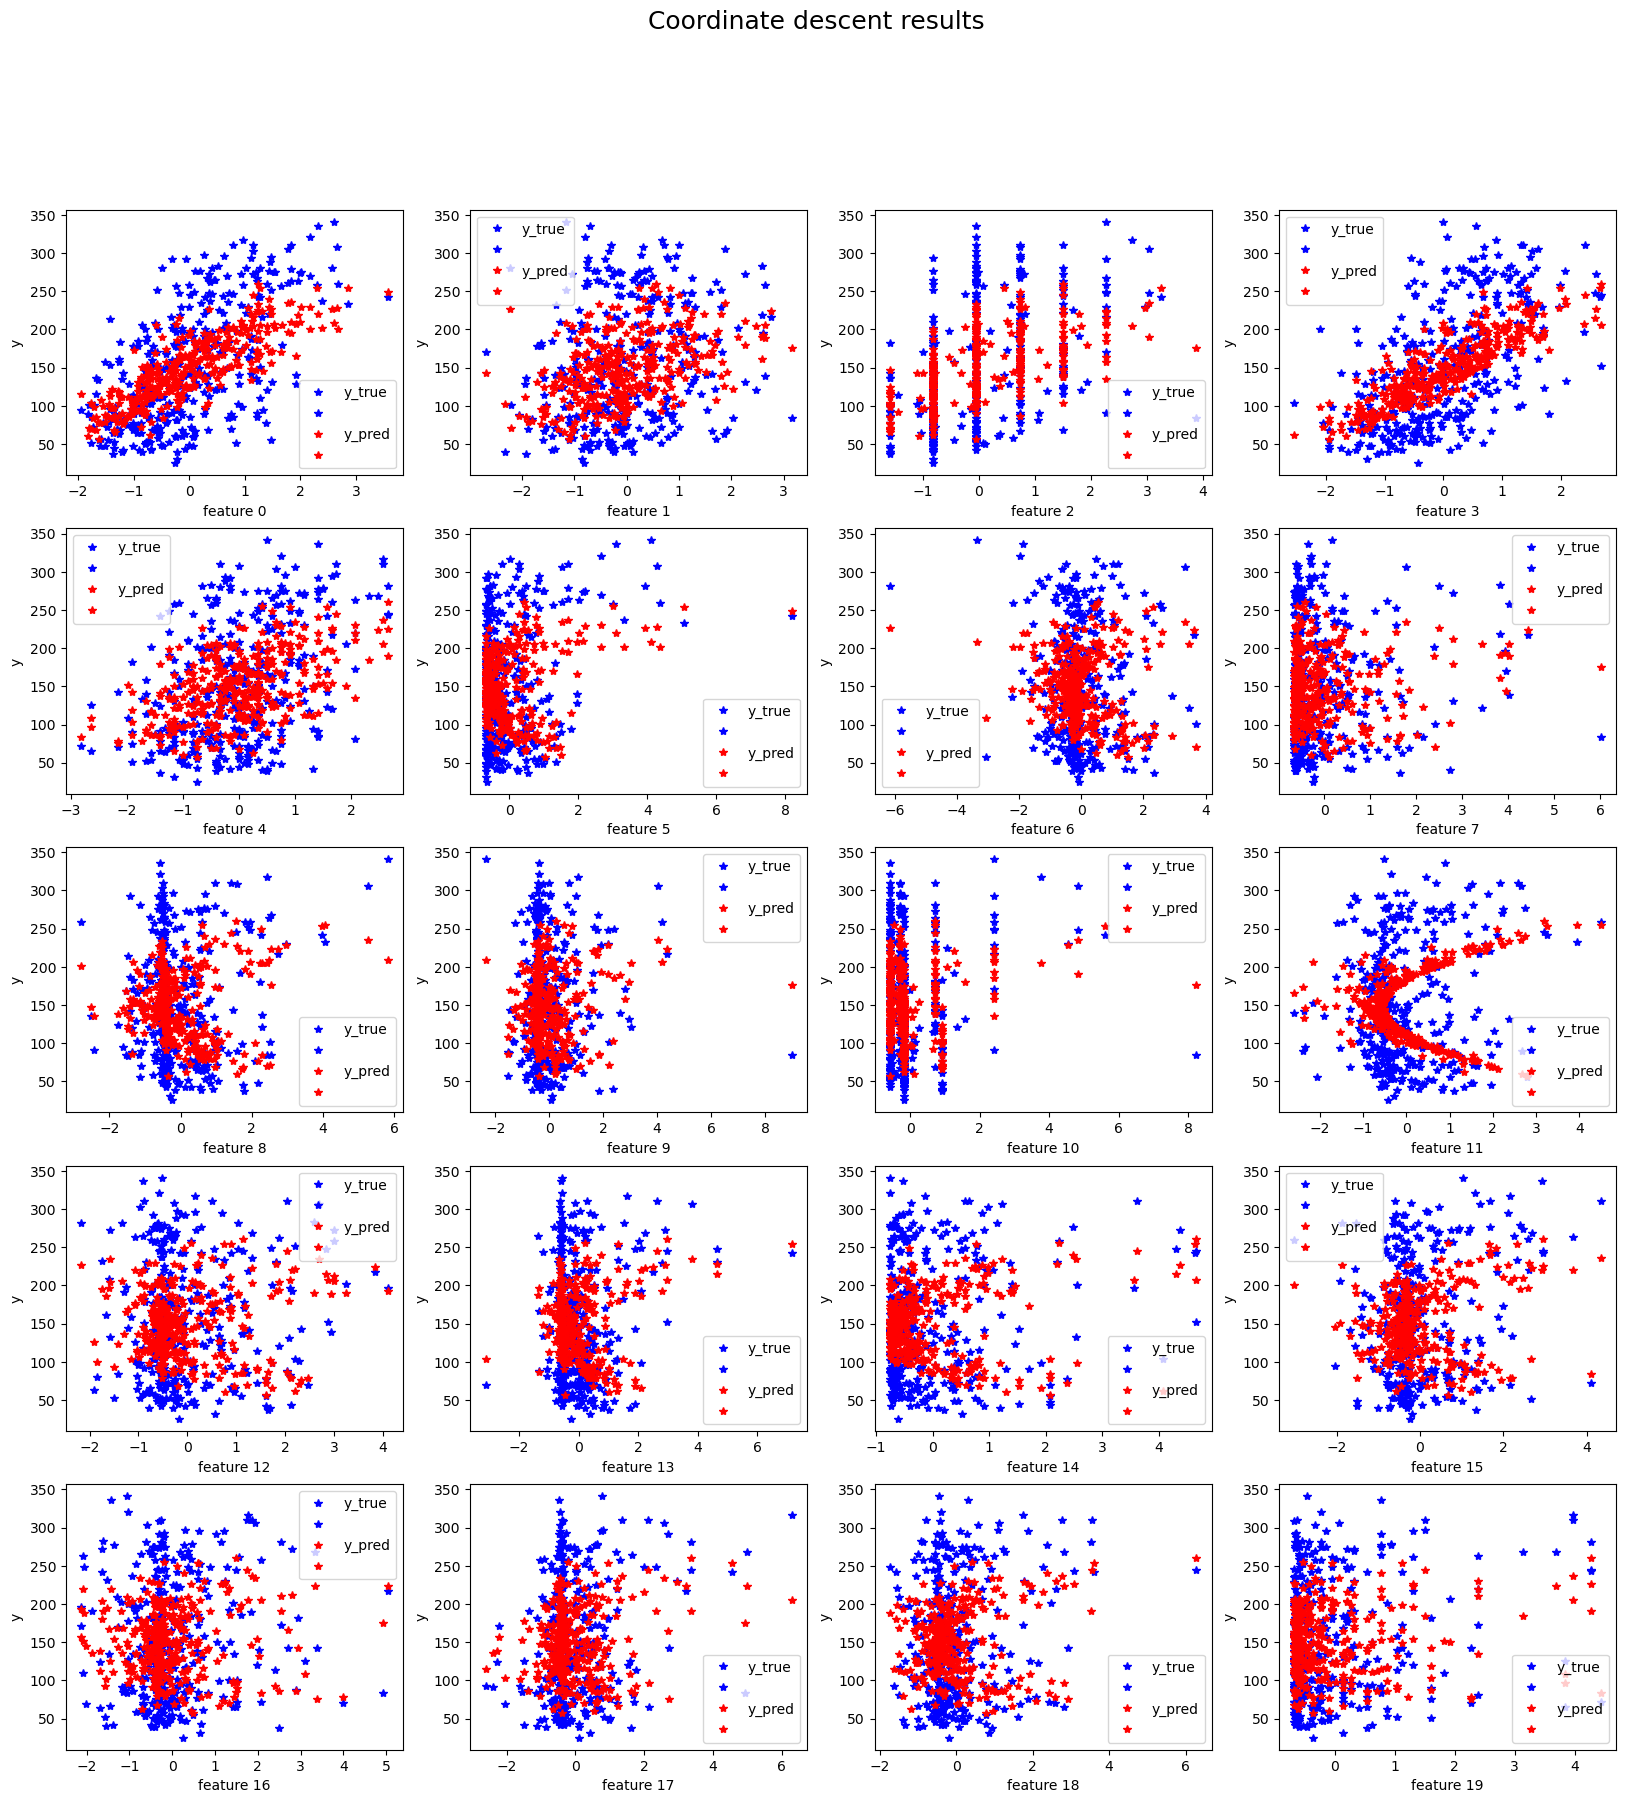

<Figure size 640x480 with 0 Axes>

In [152]:
fig,axs = plt.subplots(ncols = 4, nrows = 5, figsize = (20,20) )
ax = axs.ravel();
plt.figure()
for i in range(0,n_features):
    ax[i].plot(X_test[:,i],y_test,'b*')
    ax[i].plot(X_train[:,i],y_train,'b*')
    ax[i].plot(X_train[:,i],y_pred_train_c,'r*')
    ax[i].plot(X_test[:,i],y_pred_test_c,'r*')
    ax[i].legend(['y_true',' ','y_pred',' '])
    ax[i].set_xlabel('feature '+str(i))
    ax[i].set_ylabel('y')
fig.suptitle('Coordinate descent results',fontsize=18)

## Produkcijski model

Produkcijski model bi kao ulaz primao podatke za svako obelezje( u obliku vektora ili matrice), a kao izlaz bi vracao predikciju koju mozemo sracunati na osnovu vec naucenih vrednosti parametara i intercepta. ( Isto se ophodimo prema tim podacima kao prema nasem test skupu).

In [154]:
def predict(X):
    return np.dot(X_train, best_theta_c)+y_mean;